In [1]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn import Module

from stable_baselines3 import DDPG, SAC, TD3, DQN, PPO
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.utils import polyak_update

from tqdm import tqdm
import numpy as np

import os, shutil, sys
sys.path.append(os.path.abspath('./env'))
sys.path.append(os.path.abspath('./common'))

from env.env_simple_move import HumanMoveSimpleAction
from env.env_move_sector import HumanMoveSectorAction
from common.nets import MoveNet

from pytz import timezone
from datetime import datetime

TZ = timezone('Europe/Moscow')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DEVICE

device(type='cuda')

In [3]:
env = HumanMoveSimpleAction()
n_state = env.observation_space.shape[0]
n_action = env.action_space.shape[0]
n_hidden = 256
lr = 0.005

In [49]:
env = HumanMoveSectorAction(object_ignore=True)
n_state = env.observation_space.shape[0]
n_action = env.action_space.shape[0]
n_hidden = 256
lr = 0.003


In [40]:
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
     
model = TD3('MlpPolicy', env, action_noise=action_noise, device=DEVICE)

In [50]:
model = DDPG('MlpPolicy', env, device=DEVICE)

In [51]:
model.policy

TD3Policy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (mu): Sequential(
      (0): Linear(in_features=40, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=300, bias=True)
      (3): ReLU()
      (4): Linear(in_features=300, out_features=3, bias=True)
      (5): Tanh()
    )
  )
  (actor_target): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (mu): Sequential(
      (0): Linear(in_features=40, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=300, bias=True)
      (3): ReLU()
      (4): Linear(in_features=300, out_features=3, bias=True)
      (5): Tanh()
    )
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=43, out_featu

In [52]:
def update(model, state, action, q_v):
    criterion = torch.nn.MSELoss()
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
    action = torch.tensor(action, dtype=torch.float32, device=DEVICE)
    q_v = torch.tensor([q_v], dtype=torch.float32, device=DEVICE)

    action_by_net = model.actor.mu.forward(state)
    loss = criterion(action_by_net, action)

    model.actor.optimizer.zero_grad()
    loss.backward()
    model.actor.optimizer.step()

    critic_loss = None
    qvalue_input = torch.cat([state, action], dim=0)
    q_by_net = tuple(q_net(qvalue_input) for q_net in model.critic.q_networks)
    critic_loss = sum(criterion(current_q, q_v) for current_q in q_by_net)

    model.critic.optimizer.zero_grad()
    critic_loss.backward()
    model.critic.optimizer.step()

    polyak_update(model.actor.parameters(), model.actor_target.parameters(), model.tau)
    polyak_update(model.critic.parameters(), model.critic_target.parameters(), model.tau)



def get_action(model, state):
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    action = model.actor.mu.forward(state)
    action = action.detach().cpu().numpy()[0]
    action = np.clip(action, -1.0, 1.0)
    return action

Обучение с учителем

In [53]:
n_episode = 10000
total_reward_episode = np.zeros(n_episode)

for n in tqdm(range(n_episode)):
    state, _ = env.reset()
    action = get_action(model, state)
    teach_action = env.teach_action()
    next_state, reward, is_done, is_break, _ = env.step(teach_action)
    update(model, state, teach_action, reward)

100%|██████████| 10000/10000 [02:48<00:00, 59.50it/s]


Проверка модели

In [54]:
n_episode = 10
total_reward_episode = np.zeros(n_episode)

for n in tqdm(range(n_episode)):

    state, _ = env.reset()
    
    is_done = False
    is_break = False
    sum_reward = 0

    while not is_done and not is_break:
        #action = model.get_action(state)
        action, _ = model.predict(state)
        next_state, reward, is_done, is_break, _ = env.step(action)
        sum_reward += reward
        state = next_state

    total_reward_episode[n] = sum_reward

100%|██████████| 10/10 [01:21<00:00,  8.16s/it]


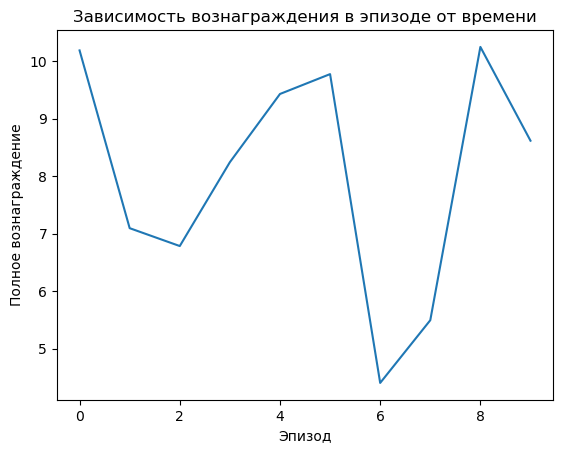

In [55]:
import matplotlib.pyplot as plt

plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [46]:
seed = int( datetime.now(TZ).strftime("%H%M%S") )
#env_render = HumanMoveSimpleAction(seed=seed, target_point_rand=True, render_mode = 'human')
env_render = HumanMoveSectorAction(seed=seed, target_point_rand=True, object_ignore=True, render_mode = 'human')
total_reward = 0.
step_reward = []
observation, _ = env_render.reset()
terminated = False
truncated = False
while not terminated and not truncated:
    #action = model.get_action(observation)
    action, _ = model.predict(observation)

    observation, reward, terminated, truncated, _ = env_render.step(action)
    total_reward += reward
    step_reward.append(reward)

total_reward

10.314715433080625

In [47]:
env_render.close()

In [16]:
torch.save(model.net.state_dict(), './teached/sector_move.pth')

In [35]:
model.save('./teached/simple_move_TD3')

In [48]:
model.save('./teached/sector_move_TD3')

In [ ]:
model.save('./teached/sector_move_DDPG')

In [36]:
read_model = TD3.load('./teached/simple_move_TD3', device='cuda')

In [37]:
env_render = HumanMoveSimpleAction(render_mode = 'human',target_point_rand=True)
seed = int( datetime.now(TZ).strftime("%H%M%S") )
total_reward = 0.
step_reward = []
observation, _ = env_render.reset(seed=seed)
terminated = False
truncated = False
while not terminated and not truncated:
    action, _ = read_model.predict(observation)
    observation, reward, terminated, truncated, _ = env_render.step(action)
    total_reward += reward
    step_reward.append(reward)

total_reward

3.1231783541605296

In [38]:
env_render.close()